# Evolution Strategies Testing

Testing Cross Entropy Method and Self-adapting Evolution strategy (1+1) on the flatland environment with logistic regression policy.
Evaluating the most efficient parameters for CEM algo.

In [2]:
%load_ext autoreload
%autoreload 2
from src.evolution_algos import cem_uncorrelated, saes_1_1, ObjectiveFunction
from src.evolution_policy import NeuralNetworkPolicy, LogisticRegression

import numpy as np
from src.test_utils import RenderWrapper
from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.persistence import RailEnvPersister
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
# from flatland_cutils import TreeObsForRailEnv as TreeCutils
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

from flatland.utils.rendertools import RenderTool

from src.observation_utils import normalize_observation

import time

In [3]:
# Create the environment
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [4]:
# Initializing policy to logistic regression
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
policy = LogisticRegression(state_size, 5)
print(policy.num_params)

1155


In [5]:
# test on one step

theta = np.random.rand(policy.num_params)

obs, info = env.reset()
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
actions = {}
for agent in env.get_agent_handles():
    actions[agent] = policy.act(agent_obs[agent], theta)

obs, all_rewards, done, _ = env.step(actions)

print(all_rewards)
    

{0: 0, 1: 0}


In [6]:
# get average result on 10 runs (used to tune parameters of the model)

for i in range(10):
    # Cross entropy method

    # Create the objective function
    objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

    init_mean_array = np.random.random(size = policy.num_params)
    init_var_array = np.ones(shape=policy.num_params) * 100.
    hist_dict = {}
    cem = cem_uncorrelated(
        objective_function,
        mean_array = init_mean_array,
        var_array = init_var_array,
        max_iterations=50,
        sample_size=50,
        elite_frac=0.3,
        print_every=5,
        success_score=15,
        hist_dict=hist_dict
    )

iteration :  0
sorted samples :  [2.0, 11.0, 20.0, 21.0, 22.0, 22.0, 23.0, 23.0, 23.0, 29.0, 29.0, 31.0, 34.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 39.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 42.0, 42.0, 43.0, 43.0, 46.0, 46.0, 46.0, 46.0, 46.0, 48.0, 54.0, 54.0, 55.0, 59.0]
37.1
iteration :  5
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 2.0, 3.0, 12.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 24.0, 27.0, 29.0, 29.0, 30.0, 30.0, 39.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 43.0, 43.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 45.0, 45.0]
21.72
Success! Algorithm converged in  9  iterations
iteration :  0
sorted samples :  [-0.0, -0.0, -0.0, 10.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 27.0, 28.0, 28.0, 28.0, 28.0, 31.0, 31.0, 31.0, 32.0, 34.0, 36.0, 36.0, 36.0, 37.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 42.0, 44.0, 46.

In [8]:
## One run only
# Cross entropy method

# Create the objective function
objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

init_mean_array = np.random.random(size = policy.num_params)
init_var_array = np.ones(shape=policy.num_params) * 100.
hist_dict = {}
theta = cem_uncorrelated(
    objective_function,
    mean_array = init_mean_array,
    var_array = init_var_array,
    max_iterations=50,
    sample_size = 50,
    elite_frac=0.1,
    print_every=5,
    success_score=15,
    hist_dict=hist_dict
)

iteration :  0
sorted samples :  [-0.0, 16.0, 18.0, 19.0, 20.0, 20.0, 21.0, 21.0, 23.0, 23.0, 23.0, 23.0, 27.0, 28.0, 28.0, 29.0, 30.0, 33.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 40.0, 41.0, 41.0, 41.0, 42.0, 42.0, 43.0, 44.0, 45.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 53.0, 53.0, 54.0, 55.0]
36.02
iteration :  5
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 27.0, 28.0, 28.0, 28.0, 29.0, 29.0, 29.0, 29.0, 30.0, 31.0, 32.0, 39.0, 39.0, 41.0, 41.0, 41.0, 42.0, 42.0, 42.0, 42.0, 43.0, 43.0, 44.0, 44.0, 44.0, 44.0]
19.02
iteration :  10
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 27.0, 27.0, 27.0, 28.0, 28.0, 30.0, 30.0, 30.0, 30.0, 31.0, 31.0, 31.0, 31.0, 31.0, 32.0, 32.0, 39.0, 41.0, 41.0, 41.0, 41.0, 42.0, 43.0, 44.

In [59]:
# 10 runs of SAES 1+1 to compare with CEM (used to tune parameters of the model)

for i in range(10):

    hist_dict = {}

    init_x_array = np.random.random(size = policy.num_params)
    init_sigma_array = np.ones(shape=policy.num_params) * 100.



    objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=2 , max_time_steps=200)

    saes = saes_1_1(
        objective_function,
        x_array = init_x_array,
        sigma_array = init_sigma_array,
        tau = 0.01,
        max_iterations=100,
        print_every=1,
        success_score=10,
        hist_dict=hist_dict
    )

Iteration 0/100: Score = 28.5
Iteration 1/100: Score = 38.5
Iteration 2/100: Score = 34.0
Iteration 3/100: Score = 34.5
Iteration 4/100: Score = 25.5
Iteration 5/100: Score = 42.5
Iteration 6/100: Score = 33.0
Iteration 7/100: Score = 31.0
Iteration 8/100: Score = 24.5
Iteration 9/100: Score = -0.0
Success after 9 iterations!
Iteration 0/100: Score = 28.0
Iteration 1/100: Score = 48.5
Iteration 2/100: Score = 42.0
Iteration 3/100: Score = 39.0
Iteration 4/100: Score = 31.0
Iteration 5/100: Score = 38.0
Iteration 6/100: Score = 29.0
Iteration 7/100: Score = 29.5
Iteration 8/100: Score = 28.5
Iteration 9/100: Score = 29.5
Iteration 10/100: Score = 30.0
Iteration 11/100: Score = 18.0
Iteration 12/100: Score = 15.0
Iteration 13/100: Score = 27.0
Iteration 14/100: Score = 22.0
Iteration 15/100: Score = 24.5
Iteration 16/100: Score = 21.5
Iteration 17/100: Score = 21.5
Iteration 18/100: Score = 23.5
Iteration 19/100: Score = 25.0
Iteration 20/100: Score = 23.5
Iteration 21/100: Score = 22.0


In [ ]:
# show reward on a few episodes

for i in range(5):
    print(objective_function(saes))

28.5
-0.0
22.0
-0.0
19.5


In [7]:
## visualization of the environment and the policy

# Create the environment
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=30,
    height=20,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=3,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=4,
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [8]:
# Initializing policy
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
policy = LogisticRegression(state_size, 5)
print(policy.num_params)

1155


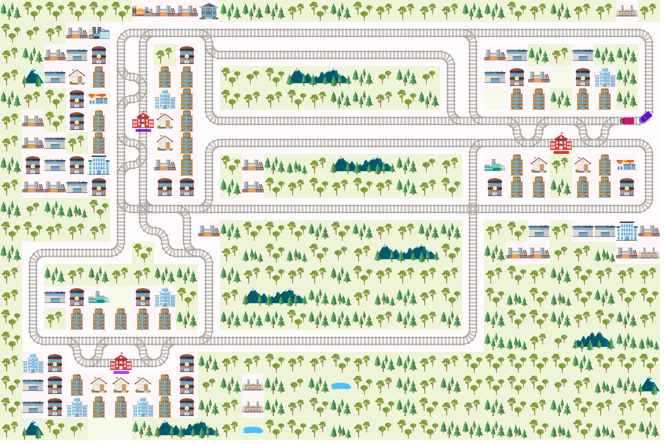

Stopped at time step  108
{0: 0, 1: -71, 2: 0, 3: -52}


In [10]:
# Visualizing using CEM + linear regression

state, info = env.reset()
env_renderer = RenderWrapper(env,real_time_render=True, force_gif=False)

max_time_steps = 500

for t in range(max_time_steps):
    env_renderer.render()
    time.sleep(0.2)
    
    agent_obs = [None] * env.get_num_agents()
    for agent in env.get_agent_handles():
        if state[agent]:
            agent_obs[agent] = normalize_observation(state[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
    actions = {}
    for agent in env.get_agent_handles():
        actions[agent] = policy.act(agent_obs[agent], cem)
    
    state, all_rewards, done, info = env.step(actions)
    #print("step : ", t)
    #print("rewards : ", all_rewards)
    #print("actions : ", actions)
    #total_rewards += sum(all_rewards.values())

    if done['__all__']:
        print("Stopped at time step ", t)
        print(all_rewards)
        break